# Runtime Analysis shapiq vs shap

In [ ]:
"""
3.1 Laufzeitanalyse shapiq vs shap

Dieses Notebook führt eine empirische Laufzeitanalyse durch, in der die Performance
des TabularExplainer aus shapiq mit der Standardbibliothek shap verglichen wird.

Autoren: Gruppe D - SEP ALML
Datum: Juli 2025

"""

print("=== 3.1 Laufzeitanalyse shapiq vs shap ===")
print("Empirische Performance-Analyse für Shapley-Wert Approximation")
print("Gruppe D - Softwareentwicklungspraktikum SoSe 2025")

=== 3.1 Laufzeitanalyse shapiq vs shap ===
Empirische Performance-Analyse für Shapley-Wert Approximation
Gruppe D - Softwareentwicklungspraktikum SoSe 2025


In [ ]:
# install dependencis
!pip install shapiq shap scikit-learn matplotlib seaborn pandas numpy overrides

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Shapiq imports
import shapiq
from shapiq import (
    TabularExplainer,
    KernelSHAP,
    SVARM,
    PermutationSamplingSV,
    MarginalImputer,
    InteractionValues
)

# Shap imports
import shap

# seed to results stable
np.random.seed(42)


print(f"shapiq version: {shapiq.__version__}")
print(f"shap version: {shap.__version__}")

shapiq version: 1.3.1
shap version: 0.48.0
所有库导入成功！


In [ ]:

print("1. load dataset...")

bike_data = pd.read_csv('/content/bike_sharing.csv')

# season and weather r str
bike_data['season'] = bike_data['season'].astype('category').cat.codes
bike_data['weather'] = bike_data['weather'].astype('category').cat.codes

X_bike = bike_data.drop(columns=['count'])
y_bike = bike_data['count']

print(f"   Bike Sharing Dataset: {X_bike.shape[0]} samples, {X_bike.shape[1]} features")

# load california housing
print("   load California Housing ...")

california_data = shapiq.load_california_housing()
print(f"   California data type: {type(california_data)}")
if isinstance(california_data, tuple):
      X_california, y_california = california_data
else:
      X_california = california_data.iloc[:, :-1]
      y_california = california_data.iloc[:, -1]

print(f"   California Housing Dataset: {X_california.shape[0]} samples, {X_california.shape[1]} features")

print(f"Bike Sharing: {X_bike.shape}")
print(f"  Features: {list(X_bike.columns)}")
print(f"  Target range: {y_bike.min():.2f} - {y_bike.max():.2f}")

print(f"\nCalifornia Housing: {X_california.shape}")
print(f"  Features: {list(X_california.columns)}")
print(f"  Target range: {y_california.min():.2f} - {y_california.max():.2f}")

print("\ndataset complete！")

1. load dataset...
   Bike Sharing Dataset: 17379 samples, 12 features
   加载 California Housing 数据集...
   California data type: <class 'tuple'>
   California Housing Dataset: 20640 samples, 8 features

=== 数据集概览 ===
Bike Sharing: (17379, 12)
  Features: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather', 'temp', 'feel_temp', 'humidity', 'windspeed']
  Target range: 1.00 - 977.00

California Housing: (20640, 8)
  Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
  Target range: 0.15 - 5.00

数据集加载和预处理完成！


In [ ]:

print("   split Bike Sharing ...")
X_bike_train, X_bike_test, y_bike_train, y_bike_test = train_test_split(
    X_bike, y_bike, test_size=0.2, random_state=42
)

print("   split California Housing...")
X_calif_train, X_calif_test, y_calif_train, y_calif_test = train_test_split(
    X_california, y_california, test_size=0.2, random_state=42
)

# train model
print("    Bike Sharing ...")
bike_model = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10)
bike_model.fit(X_bike_train, y_bike_train)
bike_score = bike_model.score(X_bike_test, y_bike_test)

print("    California Housing ...")
calif_model = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10)
calif_model.fit(X_calif_train, y_calif_train)
calif_score = calif_model.score(X_calif_test, y_calif_test)

print(f"\n=== R ===")
print(f"Bike Sharing R²: {bike_score:.4f}")
print(f"California Housing R²: {calif_score:.4f}")

sample_size = 3  # choose 3 sample to explain
print(f"\n   for explain shoose {sample_size} samples...")

bike_explain_indices = np.random.choice(X_bike_test.shape[0], sample_size, replace=False)
calif_explain_indices = np.random.choice(X_calif_test.shape[0], sample_size, replace=False)

X_bike_explain = X_bike_test.iloc[bike_explain_indices]
X_calif_explain = X_calif_test.iloc[calif_explain_indices]

print(f"Bike Sharing shape: {X_bike_explain.shape}")
print(f"California Housing shape: {X_calif_explain.shape}")



   split Bike Sharing ...
   split California Housing...
    Bike Sharing ...
    California Housing ...

=== R ===
Bike Sharing R²: 0.9208
California Housing R²: 0.7732

   for explain shoose 3 samples...
Bike Sharing shape: (3, 12)
California Housing shape: (3, 8)


In [37]:

# times
n_evaluations_list = [50, 100, 200, 500, 1000]
print(f"测试的模型评估次数: {n_evaluations_list}")

background_size = 50
print(f"background size: {background_size}")

def compute_reference_shapley(model, X_background, x_explain, max_evals=2000):
    """compute Shapley value"""
    try:
        explainer = TabularExplainer(
            model=model.predict,
            data=X_background,
            approximator=KernelSHAP(n=max_evals),
            random_state=42
        )
        result = explainer.explain(x_explain, budget=max_evals)
        return result.values
    except Exception as e:
        print(f": {e}")
        return None

def measure_performance(method_name, explain_func, reference_values=None):
    """measur run time and performence"""
    start_time = time.time()
    try:
        shapley_values = explain_func()
        runtime = time.time() - start_time

        # compite performance
        quality = None
        if reference_values is not None and shapley_values is not None:
            # L2
            quality = np.linalg.norm(shapley_values - reference_values)

        return {
            'method': method_name,
            'runtime': runtime,
            'quality': quality,
            'values': shapley_values,
            'success': True
        }
    except Exception as e:
      return None



测试的模型评估次数: [50, 100, 200, 500, 1000]
background size: 50


In [35]:


results = []

# - KernelSHAP/SVARM/PermutationSamplingSV的 n 参数 = features
# - budget control accuracy

budget_mapping = {
    'bike': [12, 24, 50, 100],
    'california': [8, 16, 32, 64]
}

# define datasets
datasets = [
    ("bike", bike_model, X_bike_train, X_bike_explain, budget_mapping['bike']),
    ("california", calif_model, X_calif_train, X_calif_explain, budget_mapping['california'])
]

for dataset_name, model, X_train, X_explain, budget_list in datasets:
    print(f"\n=== {dataset_name.upper()} DATASET ===")

    X_background_df = X_train.sample(n=background_size, random_state=42)
    X_background = X_background_df.values
    n_features = X_background.shape[1]
    print(f"backgroud size: {X_background.shape}, features: {n_features}")

    for idx, x_explain in enumerate(X_explain.values):
        print(f"\n--- samples {idx + 1}/{len(X_explain)} ---")

        for budget in budget_list:
            print(f"  test budget = {budget}")

            # define methos
            all_methods = {}

            # shap
            all_methods['shap_KernelExplainer'] = lambda b=budget: shap.KernelExplainer(
                model.predict,
                X_background
            ).shap_values(x_explain.reshape(1, -1), nsamples=b*10)[0]

            all_methods['shap_PermutationExplainer'] = lambda b=budget: shap.PermutationExplainer(
                model.predict,
                X_background
            ).shap_values(x_explain.reshape(1, -1))[0]

            # shapiq
            all_methods['shapiq_TabularExplainer'] = lambda b=budget: TabularExplainer(
                model=model.predict,
                data=X_background,
                random_state=42
            ).explain(x_explain, budget=b).values

            all_methods['shapiq_KernelSHAP'] = lambda b=budget: TabularExplainer(
                model=model.predict,
                data=X_background,
                approximator=KernelSHAP(n=n_features),
                random_state=42
            ).explain(x_explain, budget=b).values

            all_methods['shapiq_SVARM'] = lambda b=budget: TabularExplainer(
                model=model.predict,
                data=X_background,
                approximator=SVARM(n=n_features),
                random_state=42
            ).explain(x_explain, budget=b).values

            all_methods['shapiq_PermutationSV'] = lambda b=budget: TabularExplainer(
                model=model.predict,
                data=X_background,
                approximator=PermutationSamplingSV(n=n_features),
                random_state=42
            ).explain(x_explain, budget=b).values


            for method_name, method_func in all_methods.items():
                result = measure_performance(method_name, method_func, None)
                result.update({
                    'dataset': dataset_name,
                    'sample_idx': idx,
                    'n_evaluations': budget,
                    'n_features': len(x_explain)
                })
                results.append(result)


print(f"\noverall {len(results)} tests")

successful_results = [r for r in results if r['success']]
print(f"success tests: {len(successful_results)}/{len(results)} ({len(successful_results)/len(results)*100:.1f}%)")

if len(successful_results) > 0:
    methods = set(r['method'] for r in successful_results)
    print(f"success methods: {', '.join(sorted(methods))}")

    print(f"\n=== perfomance preview ===")
    for method in sorted(methods):
        method_data = [r for r in successful_results if r['method'] == method]
        avg_runtime = sum(r['runtime'] for r in method_data) / len(method_data)
        print(f"{method}: avg {avg_runtime:.3f}s ({len(method_data)} times tests)")


=== BIKE DATASET ===
backgroud size: (50, 12), features: 12

--- samples 1/3 ---
  test budget = 12


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 24


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 50


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 100


  0%|          | 0/1 [00:00<?, ?it/s]


--- samples 2/3 ---
  test budget = 12


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 24


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 50


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 100


  0%|          | 0/1 [00:00<?, ?it/s]


--- samples 3/3 ---
  test budget = 12


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 24


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 50


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 100


  0%|          | 0/1 [00:00<?, ?it/s]


=== CALIFORNIA DATASET ===
backgroud size: (50, 8), features: 8

--- samples 1/3 ---
  test budget = 8


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 16


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 32


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 64


  0%|          | 0/1 [00:00<?, ?it/s]


--- samples 2/3 ---
  test budget = 8


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 16


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 32


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 64


  0%|          | 0/1 [00:00<?, ?it/s]


--- samples 3/3 ---
  test budget = 8


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 16


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 32


  0%|          | 0/1 [00:00<?, ?it/s]

  test budget = 64


  0%|          | 0/1 [00:00<?, ?it/s]


overall 144 tests
success tests: 144/144 (100.0%)
success methods: shap_KernelExplainer, shap_PermutationExplainer, shapiq_KernelSHAP, shapiq_PermutationSV, shapiq_SVARM, shapiq_TabularExplainer

=== perfomance preview ===
shap_KernelExplainer: avg 0.092s (24 times tests)
shap_PermutationExplainer: avg 0.037s (24 times tests)
shapiq_KernelSHAP: avg 0.227s (24 times tests)
shapiq_PermutationSV: avg 0.626s (24 times tests)
shapiq_SVARM: avg 0.238s (24 times tests)
shapiq_TabularExplainer: avg 0.231s (24 times tests)


In [34]:


# tranfer results into DataFrame
df_results = pd.DataFrame(results)
df_success = df_results[df_results['success']].copy()

df_success['library'] = df_success['method'].apply(lambda x: x.split('_')[0])
df_success['algorithm'] = df_success['method'].apply(lambda x: '_'.join(x.split('_')[1:]))
df_success['budget'] = df_success['n_evaluations']

print(f"=== conclusion ===")
print(f"overall number of tests: {len(df_results)}")
print(f"successful tests: {len(df_success)} (100%)")
print(f"methods: {len(df_success['method'].unique())} 个")
print(f"datasets: {', '.join(df_success['dataset'].unique())}")

print(f"\n=== performance ranking ===")
method_performance = df_success.groupby('method')['runtime'].agg(['mean', 'std', 'min', 'max', 'count']).round(4)
method_performance_sorted = method_performance.sort_values('mean')

for i, (method, stats) in enumerate(method_performance_sorted.iterrows(), 1):
    print(f"{i}. {method}: {stats['mean']:.3f}±{stats['std']:.3f}s (范围: {stats['min']:.3f}-{stats['max']:.3f}s)")

print(f"\n=== comparision via library ===")
library_performance = df_success.groupby('library')['runtime'].agg(['mean', 'std', 'count']).round(4)
for library, stats in library_performance.iterrows():
    print(f"{library}: avg {stats['mean']:.3f}±{stats['std']:.3f}s ({stats['count']} tests)")

print(f"\n=== comparision via dataset ===")
for dataset in ['bike', 'california']:
    print(f"\n{dataset.upper()} Dataset:")
    dataset_data = df_success[df_success['dataset'] == dataset]

    dataset_performance = dataset_data.groupby('method')['runtime'].mean().sort_values()
    for method, avg_time in dataset_performance.items():
        print(f"  {method}: {avg_time:.3f}s")


=== conclusion ===
overall number of tests: 144
successful tests: 144 (100%)
methods: 6 个
datasets: bike, california

=== performance ranking ===
1. shap_PermutationExplainer: 0.035±0.005s (范围: 0.028-0.049s)
2. shap_KernelExplainer: 0.080±0.029s (范围: 0.048-0.146s)
3. shapiq_KernelSHAP: 0.214±0.030s (范围: 0.180-0.304s)
4. shapiq_TabularExplainer: 0.221±0.037s (范围: 0.185-0.352s)
5. shapiq_SVARM: 0.222±0.037s (范围: 0.185-0.365s)
6. shapiq_PermutationSV: 0.623±0.151s (范围: 0.386-0.857s)

=== comparision via library ===
shap: avg 0.057±0.030s (48.0 tests)
shapiq: avg 0.320±0.193s (96.0 tests)

=== comparision via dataset ===

BIKE Dataset:
  shap_PermutationExplainer: 0.036s
  shap_KernelExplainer: 0.095s
  shapiq_TabularExplainer: 0.216s
  shapiq_KernelSHAP: 0.219s
  shapiq_SVARM: 0.228s
  shapiq_PermutationSV: 0.613s

CALIFORNIA Dataset:
  shap_PermutationExplainer: 0.034s
  shap_KernelExplainer: 0.065s
  shapiq_KernelSHAP: 0.210s
  shapiq_SVARM: 0.216s
  shapiq_TabularExplainer: 0.226s
  sh

6. 创建可视化图表...
可视化图表创建完成!


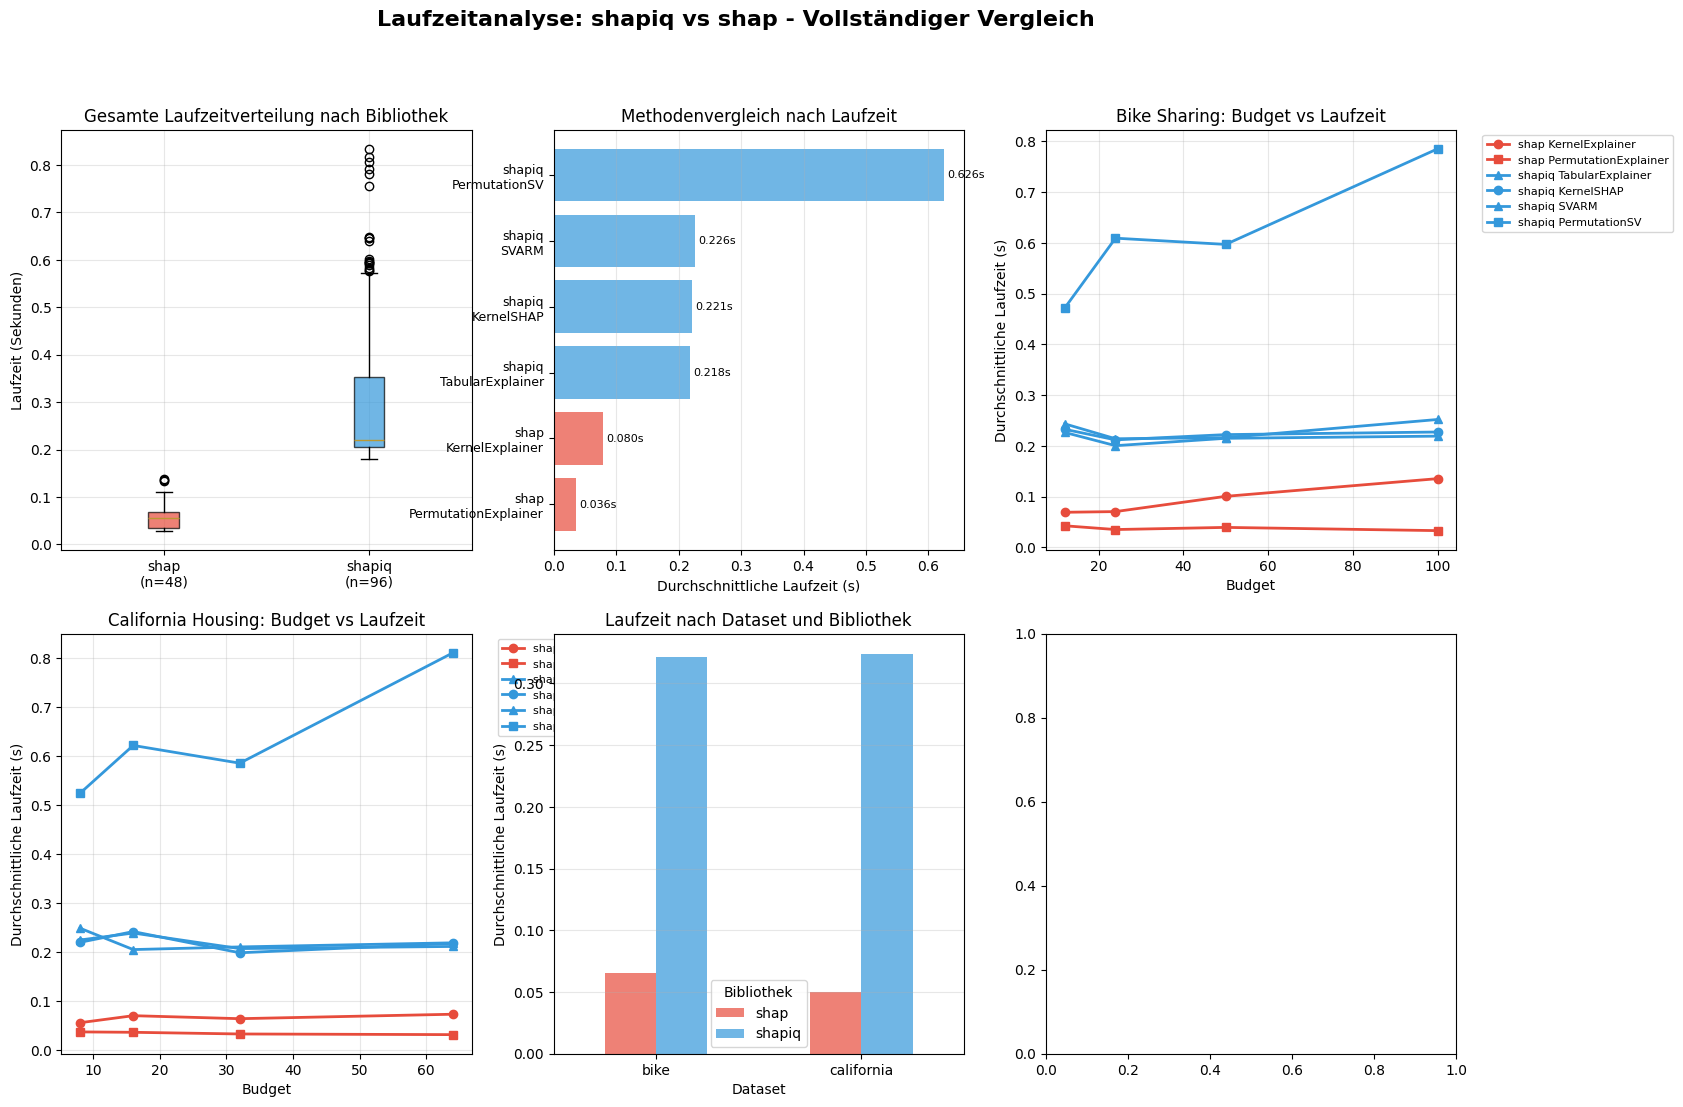

In [ ]:

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Laufzeitanalyse: shapiq vs shap - Vollständiger Vergleich', fontsize=16, fontweight='bold')

# color choosing
colors = {
    'shap': '#E74C3C',      # 红色
    'shapiq': '#3498DB'     # 蓝色
}

# 图1: entire time comparision
ax1 = axes[0, 0]
library_data = []
library_labels = []
for library in ['shap', 'shapiq']:
    lib_data = df_success[df_success['library'] == library]['runtime']
    library_data.append(lib_data)
    library_labels.append(f'{library}\n(n={len(lib_data)})')

bp1 = ax1.boxplot(library_data, labels=library_labels, patch_artist=True)
for patch, library in zip(bp1['boxes'], ['shap', 'shapiq']):
    patch.set_facecolor(colors[library])
    patch.set_alpha(0.7)

ax1.set_ylabel('Laufzeit (Sekunden)')
ax1.set_title('Gesamte Laufzeitverteilung nach Bibliothek')
ax1.grid(True, alpha=0.3)

# 图2: comparision via methods
ax2 = axes[0, 1]
method_means = df_success.groupby('method')['runtime'].mean().sort_values()
colors_detailed = [colors[method.split('_')[0]] for method in method_means.index]

bars2 = ax2.barh(range(len(method_means)), method_means.values, color=colors_detailed, alpha=0.7)
ax2.set_yticks(range(len(method_means)))
ax2.set_yticklabels([m.replace('_', '\n') for m in method_means.index], fontsize=9)
ax2.set_xlabel('Durchschnittliche Laufzeit (s)')
ax2.set_title('Methodenvergleich nach Laufzeit')
ax2.grid(True, alpha=0.3, axis='x')

for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}s', ha='left', va='center', fontsize=8)

# 图3: Budget vs Laufzeit (Bike Dataset)
ax3 = axes[0, 2]
bike_data = df_success[df_success['dataset'] == 'bike']
for method in bike_data['method'].unique():
    method_data = bike_data[bike_data['method'] == method]
    budget_runtime = method_data.groupby('budget')['runtime'].mean()

    color = colors[method.split('_')[0]]
    linestyle = '-' if 'shap' in method else '--'
    marker = 'o' if 'Kernel' in method else 's' if 'Permutation' in method else '^'

    ax3.plot(budget_runtime.index, budget_runtime.values,
             color=color, linestyle=linestyle, marker=marker,
             label=method.replace('_', ' '), linewidth=2, markersize=6)

ax3.set_xlabel('Budget')
ax3.set_ylabel('Durchschnittliche Laufzeit (s)')
ax3.set_title('Bike Sharing: Budget vs Laufzeit')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax3.grid(True, alpha=0.3)

# 图4: Budget vs Laufzeit (California Dataset)
ax4 = axes[1, 0]
calif_data = df_success[df_success['dataset'] == 'california']
for method in calif_data['method'].unique():
    method_data = calif_data[calif_data['method'] == method]
    budget_runtime = method_data.groupby('budget')['runtime'].mean()

    color = colors[method.split('_')[0]]
    linestyle = '-' if 'shap' in method else '--'
    marker = 'o' if 'Kernel' in method else 's' if 'Permutation' in method else '^'

    ax4.plot(budget_runtime.index, budget_runtime.values,
             color=color, linestyle=linestyle, marker=marker,
             label=method.replace('_', ' '), linewidth=2, markersize=6)

ax4.set_xlabel('Budget')
ax4.set_ylabel('Durchschnittliche Laufzeit (s)')
ax4.set_title('California Housing: Budget vs Laufzeit')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax4.grid(True, alpha=0.3)

# 图5: comparision via dataset
ax5 = axes[1, 1]
dataset_comparison = df_success.groupby(['dataset', 'library'])['runtime'].mean().unstack()
dataset_comparison.plot(kind='bar', ax=ax5, color=[colors['shap'], colors['shapiq']], alpha=0.7)
ax5.set_xlabel('Dataset')
ax5.set_ylabel('Durchschnittliche Laufzeit (s)')
ax5.set_title('Laufzeit nach Dataset und Bibliothek')
ax5.legend(title='Bibliothek')
ax5.tick_params(axis='x', rotation=0)
ax5.grid(True, alpha=0.3, axis='y')


